In [1]:
import os
import pandas as pd
import numpy as np
import scipy
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
# import seaborn as sns
from collections import defaultdict
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
# from sklearn import datasets

import configparser
config = configparser.ConfigParser()
config.read_file(open('config/config-azure.ini'))

client_attributes_file_path = config['data-files']['clients_attributes']
active_promos_file_path = config['data-files']['active_promos']
executed_promos_file_path = config['data-files']['executed_promos']
sales_file_path = config['data-files']['sales']


In [2]:
sales = pd.read_csv(sales_file_path, encoding='latin-1')
sales

Cliente   Año  Mes  ClaseEnvase  SegmentoPrecio  Marca  Cupo  \
0              1  2018    1            2             2.0     44  10.0   
1              1  2018    1            2             4.0     18  16.0   
2              1  2018    6            2             1.0      2   6.0   
3              1  2018    7            1             2.0     37  34.0   
4              1  2018    8            2             1.0      2  16.0   
...          ...   ...  ...          ...             ...    ...   ...   
1894247    15068  2019    8            1             2.0     44  32.0   
1894248    15069  2019    3            1             2.0     44  32.0   
1894249    15069  2019    4            1             2.0     44  32.0   
1894250    15069  2019    4            2             1.0      2   6.0   
1894251    15069  2019    7            1             2.0     44  29.0   

               Nr    Hl    Dcto  
0         6352.94  0.03     0.0  
1        99130.50  0.45     0.0  
2        11605.40  0.07 -2880.0  
3         1944.01  0.01     0.0  
4        16250.18  0.06     0.0  
...           ...   ...     ...  
1894247   3777.28  0.01     0.0  
1894248   6295.46  0.02     0.0  
1894249   6295.46  0.02     0.0  
1894250  15741.56  0.08     0.0  
1894251  16102.33  0.09     0.0  

[1894252 rows x 10 columns]

In [3]:
# 0	297601	8410	29	9
# sales[(sales['Cliente'] == 8410) & (sales['Marca'] == 29) & (sales['Cupo'] == 9)]
x = sales[(sales['Cliente'] == 8410) & (sales['Marca'] == 29) & (sales['Cupo'] == 9)]
x['Cliente']

853830    8410
Name: Cliente, dtype: int64

In [4]:
executed_promos = pd.read_csv(executed_promos_file_path, encoding='latin-1')
sanitized_executed_promos = executed_promos.drop_duplicates(subset = ['Cliente', 'Marca', 'Cupo'])
sanitized_executed_promos

CodigoDC  Cliente  Marca  Cupo
0        297601     8410     29     9
1        297601     9337     29     9
2        309843     7404     40    16
3        309874     4017     40    16
4        309910     6316     40    16
...         ...      ...    ...   ...
27763    646815     2144     29     9
27764    646976       28     29     9
27765    647188    10023     29     9
27766    648099    10193     29     9
27791    651597     4430     40    16

[8426 rows x 4 columns]

In [5]:
active_promos = pd.read_csv(active_promos_file_path, encoding='latin-1')
active_promos

CodigoDC  Marca  Cupo Fecha_Desde Fecha_Hasta  Cliente
0         297601     29     9  2018-08-06  2018-08-30     3213
1         297601     29     9  2018-08-06  2018-08-30     3795
2         297601     29     9  2018-08-06  2018-08-30    11816
3         298856     40    16  2018-08-12  2018-08-19     8444
4         309916     40    16  2018-08-12  2018-08-19     8488
...          ...    ...   ...         ...         ...      ...
422432    688354     40    16  2019-09-25  2019-09-26    14435
422433    688355     29     9  2019-09-25  2019-09-26      320
422434    688355     29     9  2019-09-25  2019-09-26     3117
422435    688355     29     9  2019-09-25  2019-09-26     3503
422436    688355     29     9  2019-09-25  2019-09-26     6372

[422437 rows x 6 columns]

In [6]:
clients_attributes = pd.read_csv(client_attributes_file_path, encoding='latin-1')
clients_attributes

Cliente FechaAltaCliente  Region  Gerencia  SubCanal  TipoPoblacion  \
0            1       2009-03-03       4        21        12              1   
1            9       2009-03-03       4        21         9              2   
2           15       2009-03-03       4        21         9              2   
3           37       2009-03-03       4        21        16              2   
4           43       2009-03-03       4        21         9              2   
...        ...              ...     ...       ...       ...            ...   
15064    15040       2019-03-07       1        16         9              2   
15065    15043       2019-03-07       1        20        15              2   
15066    15052       2019-03-09       3         7        10              2   
15067    15065       2019-03-16       4        21         9              2   
15068    15069       2019-03-18       4        14         9              2   

       Estrato  EF  
0            1   1  
1            3   1  
2            3   0  
3            3   1  
4            3   0  
...        ...  ..  
15064        1   0  
15065        2   1  
15066        2   0  
15067        2   0  
15068        1   0  

[15069 rows x 8 columns]

In [7]:
sales_exec_promos = sales.merge(sanitized_executed_promos, how = 'left', on = ['Cliente', 'Marca', 'Cupo'])
sales_exec_promos.loc[sales_exec_promos['CodigoDC'].isnull() == False, 'ES_PROMO'] = 'SI'
sales_exec_promos.loc[sales_exec_promos['CodigoDC'].isnull() == True, 'ES_PROMO'] = 'NO'

sales_exec_promos


Cliente   Año  Mes  ClaseEnvase  SegmentoPrecio  Marca  Cupo  \
0              1  2018    1            2             2.0     44  10.0   
1              1  2018    1            2             4.0     18  16.0   
2              1  2018    6            2             1.0      2   6.0   
3              1  2018    7            1             2.0     37  34.0   
4              1  2018    8            2             1.0      2  16.0   
...          ...   ...  ...          ...             ...    ...   ...   
1894247    15068  2019    8            1             2.0     44  32.0   
1894248    15069  2019    3            1             2.0     44  32.0   
1894249    15069  2019    4            1             2.0     44  32.0   
1894250    15069  2019    4            2             1.0      2   6.0   
1894251    15069  2019    7            1             2.0     44  29.0   

               Nr    Hl    Dcto  CodigoDC ES_PROMO  
0         6352.94  0.03     0.0       NaN       NO  
1        99130.50  0.45     0.0       NaN       NO  
2        11605.40  0.07 -2880.0       NaN       NO  
3         1944.01  0.01     0.0       NaN       NO  
4        16250.18  0.06     0.0       NaN       NO  
...           ...   ...     ...       ...      ...  
1894247   3777.28  0.01     0.0       NaN       NO  
1894248   6295.46  0.02     0.0       NaN       NO  
1894249   6295.46  0.02     0.0       NaN       NO  
1894250  15741.56  0.08     0.0       NaN       NO  
1894251  16102.33  0.09     0.0       NaN       NO  

[1894252 rows x 12 columns]

In [8]:
df = sales_exec_promos.merge(clients_attributes, how = 'left', on = 'Cliente')
df.columns.tolist()

['Cliente',
 'Año',
 'Mes',
 'ClaseEnvase',
 'SegmentoPrecio',
 'Marca',
 'Cupo',
 'Nr',
 'Hl',
 'Dcto',
 'CodigoDC',
 'ES_PROMO',
 'FechaAltaCliente',
 'Region',
 'Gerencia',
 'SubCanal',
 'TipoPoblacion',
 'Estrato',
 'EF']

In [9]:
df=df[['Cliente','Marca', 'Cupo', 'Region', 'Gerencia', 'SubCanal', 'TipoPoblacion', 'Estrato', 'EF','ES_PROMO']]
df

Cliente  Marca  Cupo  Region  Gerencia  SubCanal  TipoPoblacion  \
0              1     44  10.0       4        21        12              1   
1              1     18  16.0       4        21        12              1   
2              1      2   6.0       4        21        12              1   
3              1     37  34.0       4        21        12              1   
4              1      2  16.0       4        21        12              1   
...          ...    ...   ...     ...       ...       ...            ...   
1894247    15068     44  32.0       1         5         9              2   
1894248    15069     44  32.0       4        14         9              2   
1894249    15069     44  32.0       4        14         9              2   
1894250    15069      2   6.0       4        14         9              2   
1894251    15069     44  29.0       4        14         9              2   

         Estrato  EF ES_PROMO  
0              1   1       NO  
1              1   1       NO  
2              1   1       NO  
3              1   1       NO  
4              1   1       NO  
...          ...  ..      ...  
1894247        3   1       NO  
1894248        1   0       NO  
1894249        1   0       NO  
1894250        1   0       NO  
1894251        1   0       NO  

[1894252 rows x 10 columns]

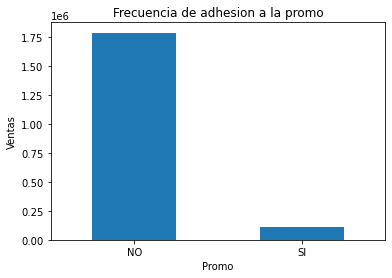

In [10]:
count_class = pd.value_counts(df['ES_PROMO'], sort = True)
count_class.plot(kind= 'bar', rot= 0)
plt.title('Frecuencia de adhesion a la promo')
plt.xlabel('Promo')
plt.ylabel('Ventas')
plt.show()

In [11]:
d = defaultdict(preprocessing.LabelEncoder)

In [12]:
tipos = df.columns.to_series().groupby(df.dtypes).groups

object_list = list(tipos[np.dtype('object')])
object_list

['ES_PROMO']

In [13]:
fit=df.apply(lambda x: d[x.name].fit_transform(x) if x.name in object_list else x)

fit.apply(lambda x: d[x.name].inverse_transform(x) if x.name in object_list else x)

df=df.apply(lambda x: d[x.name].transform(x) if x.name in object_list else x)
df.head()

Cliente  Marca  Cupo  Region  Gerencia  SubCanal  TipoPoblacion  Estrato  \
0        1     44  10.0       4        21        12              1        1   
1        1     18  16.0       4        21        12              1        1   
2        1      2   6.0       4        21        12              1        1   
3        1     37  34.0       4        21        12              1        1   
4        1      2  16.0       4        21        12              1        1   

   EF  ES_PROMO  
0   1         0  
1   1         0  
2   1         0  
3   1         0  
4   1         0

In [14]:
df.isnull().any()

Cliente          False
Marca            False
Cupo              True
Region           False
Gerencia         False
SubCanal         False
TipoPoblacion    False
Estrato          False
EF               False
ES_PROMO         False
dtype: bool

In [15]:
df['Cupo'].isnull().sum()

5

In [16]:
df = df.fillna({'Cupo': df['Cupo'].mode()[0]})
df

Cliente  Marca  Cupo  Region  Gerencia  SubCanal  TipoPoblacion  \
0              1     44  10.0       4        21        12              1   
1              1     18  16.0       4        21        12              1   
2              1      2   6.0       4        21        12              1   
3              1     37  34.0       4        21        12              1   
4              1      2  16.0       4        21        12              1   
...          ...    ...   ...     ...       ...       ...            ...   
1894247    15068     44  32.0       1         5         9              2   
1894248    15069     44  32.0       4        14         9              2   
1894249    15069     44  32.0       4        14         9              2   
1894250    15069      2   6.0       4        14         9              2   
1894251    15069     44  29.0       4        14         9              2   

         Estrato  EF  ES_PROMO  
0              1   1         0  
1              1   1         0  
2              1   1         0  
3              1   1         0  
4              1   1         0  
...          ...  ..       ...  
1894247        3   1         0  
1894248        1   0         0  
1894249        1   0         0  
1894250        1   0         0  
1894251        1   0         0  

[1894252 rows x 10 columns]

In [17]:
class_y= list(d['ES_PROMO'].classes_)
class_y

['NO', 'SI']

In [18]:
d['ES_PROMO'].transform(class_y)

array([0, 1])

In [19]:
x, y = df.iloc[:, 0:9], df.iloc[:, 9]

x_train, x_test, y_train, y_test =\
    train_test_split(x, 
                     y, 
                     test_size=0.3, 
                     stratify=y)

In [20]:
# os_us= SMOTETomek(0.8) 
# x_t_st, y_t_st= os_us.fit_sample(x_train, y_train)

In [21]:
# x_t_st= pd.DataFrame(x_t_st,columns= ['Cliente','Marca','Cupo','Region','Gerencia',
#                                       'SubCanal','TipoPoblacion','Estrato','EF'])
# y_t_st= pd.DataFrame(y_t_st,columns=['ES_PROMO'])

# df_t_st= pd.concat([x_t_st, y_t_st], axis=1)
# df_t_st.head()

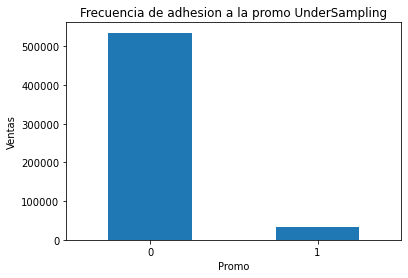

In [22]:
count_class = pd.value_counts(y_test, sort = True)
count_class.plot(kind= 'bar', rot= 0)
plt.title('Frecuencia de adhesion a la promo UnderSampling')
plt.xlabel('Promo')
plt.ylabel('Ventas')
plt.show()

In [23]:
# print(pd.value_counts(y_t_st['ES_PROMO'], sort = True))

## Regresión Logística - Entrenamiento

In [24]:
logit = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")

In [25]:
columnas = list(df.columns)
predictores = list(columnas[0:9])
target = columnas[9]

In [26]:
n = 5

In [27]:
selec = RFE(logit, n)

selec = selec.fit(df[predictores],
                  df[target].values.ravel())

/anaconda/envs/py37_default/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda/envs/py37_default/lib/python3.7/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/anaconda/envs/py37_default/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/anaconda/envs/py37_default/lib/python3.7/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/anaconda/envs/py37_default/lib/python3.7/site-packages/scipy/optimize/linesearch.p

In [28]:
print(selec.support_)

[False  True  True  True False False  True False  True]


In [29]:
print(selec.ranking_)

[5 1 1 1 4 3 1 2 1]


In [30]:
df_list = df.columns.values.tolist()
df_list

['Cliente',
 'Marca',
 'Cupo',
 'Region',
 'Gerencia',
 'SubCanal',
 'TipoPoblacion',
 'Estrato',
 'EF',
 'ES_PROMO']

In [31]:
z=zip(df_list,selec.support_, selec.ranking_)
list(z)

[('Cliente', False, 5),
 ('Marca', True, 1),
 ('Cupo', True, 1),
 ('Region', True, 1),
 ('Gerencia', False, 4),
 ('SubCanal', False, 3),
 ('TipoPoblacion', True, 1),
 ('Estrato', False, 2),
 ('EF', True, 1)]

### Estimación

In [32]:
logit_model = linear_model.LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")
logit_model.fit(x_train, y_train)

/anaconda/envs/py37_default/lib/python3.7/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/anaconda/envs/py37_default/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


LogisticRegression(class_weight='balanced', random_state=1, solver='newton-cg')

### Validación del modelo logístico

##### accuracy 

In [33]:
logit_model.score(x_train, y_train)

0.810442270448334

In [34]:
logit_model.score(x_test, y_test)

0.8100148519381427

### Predicción en base a Cliente y Promociones Activas

In [35]:
cli_active_promo = active_promos.merge(clients_attributes, how = 'left', on = 'Cliente')
columns = df.columns.tolist()
index_target = columns.index('ES_PROMO')
del columns[index_target]

cli_active_promo = cli_active_promo[columns]
cli_active_promo.head(1)

Cliente  Marca  Cupo  Region  Gerencia  SubCanal  TipoPoblacion  Estrato  \
0     3213     29     9       3         8        15              2        3   

   EF  
0   1

In [36]:
# tipos = cli_active_promo.columns.to_series().groupby(df.dtypes).groups

# tipos
# object_list = list()
# object_list

# fit=cli_active_promo.apply(lambda x: d[x.name].fit_transform(x) if x.name in object_list else x)

# fit.apply(lambda x: d[x.name].inverse_transform(x) if x.name in object_list else x)

# df=df.apply(lambda x: d[x.name].transform(x) if x.name in object_list else x)
# df.head()

prediction_results = logit_model.predict_proba(cli_active_promo.values)

prediction_results

prediction_df = pd.DataFrame(prediction_results, columns = ['No_Ejecuto_Promo', 'Ejecuto_Promo'])


In [37]:
prediction_df#[prediction_df[1] > 0.5]
pred_merged_df = pd.concat([active_promos,prediction_df],axis=1)

# resultado_final
pred_no_dupes_df = pred_merged_df.drop_duplicates(subset = ['Cliente', 'Marca', 'Cupo'])
result = pred_no_dupes_df[['Cliente', 'Marca', 'Cupo', 'Ejecuto_Promo']].set_index('Cliente')
result

Marca  Cupo  Ejecuto_Promo
Cliente                            
3213        29     9       0.746063
3795        29     9       0.730979
11816       29     9       0.734208
8444        40    16       0.783701
8488        40    16       0.795201
...        ...   ...            ...
15040       39    20       0.578856
14840       40    16       0.853836
1844        29     9       0.642179
8010        39    20       0.520166
4903        29     9       0.637062

[34551 rows x 3 columns]

In [38]:
import tempfile
output_filename = "{}/{}".format(tempfile.gettempdir(), "logit.csv")

print("GUARDANDO EL OUTPUT EN {} ...".format(output_filename))
result
result.to_csv(output_filename)

GUARDANDO EL OUTPUT EN /tmp/logit.csv ...
